# Deep Recurrent Q-Network 
This notebook provides an example implementation of a Deep Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. To learn more about DRQNs, see my blog post on them here: https://medium.com/p/68463e9aeefc .

For more reinforcment learning tutorials, as well as the additional required `gridworld.py` and `helper.py` see:
https://github.com/awjuliani/DeepRL-Agents

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
%matplotlib inline

from helper import *

### Load the game environment

In [2]:
from gridworld import gameEnv

Feel free to adjust the size of the gridworld. Making it smaller (adjusting `size`) provides an easier task for our DRQN agent, while making the world larger increases the challenge.

Initializing the Gridworld with `True` limits the field of view, resulting in a partially observable MDP. Initializing it with `False` provides the agent with the entire environment, resulting in a fully MDP.

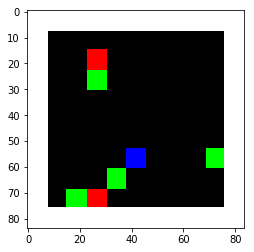

In [3]:
env = gameEnv(partial=False,size=9)

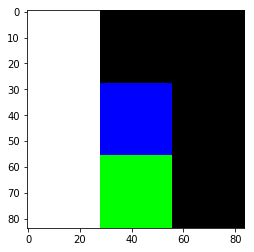

In [4]:
env = gameEnv(partial=True,size=9)

Above are examples of a starting environment in our simple game. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green squares (for +1 reward) and avoid the red squares (for -1 reward). When the agent moves through a green or red square, it is randomly moved to a new place in the environment.

### Implementing the network itself

In [5]:
class Qnetwork():
    def __init__(self,h_size,rnn_cell,myScope):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.convolution2d( \
            inputs=self.imageIn,num_outputs=32,\
            kernel_size=[8,8],stride=[4,4],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv1')
        self.conv2 = slim.convolution2d( \
            inputs=self.conv1,num_outputs=64,\
            kernel_size=[4,4],stride=[2,2],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv2')
        self.conv3 = slim.convolution2d( \
            inputs=self.conv2,num_outputs=64,\
            kernel_size=[3,3],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv3')
        self.conv4 = slim.convolution2d( \
            inputs=self.conv3,num_outputs=h_size,\
            kernel_size=[7,7],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv4')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
        self.convFlat = tf.reshape(slim.flatten(self.conv4),[self.batch_size,self.trainLength,h_size])
        self.state_in = rnn_cell.zero_state(self.batch_size, tf.float32)
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                inputs=self.convFlat,cell=rnn_cell,dtype=tf.float32,initial_state=self.state_in,scope=myScope+'_rnn')
        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        #The output from the recurrent player is then split into separate Value and Advantage streams
        self.streamA,self.streamV = tf.split(self.rnn,2,1)
        self.AW = tf.Variable(tf.random_normal([h_size//2,4]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        self.salience = tf.gradients(self.Advantage,self.imageIn)
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,4,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        
        #In order to only propogate accurate gradients through the network, we will mask the first
        #half of the losses for each trace as per Lample & Chatlot 2016
        self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
        self.maskB = tf.ones([self.batch_size,self.trainLength//2])
        self.mask = tf.concat([self.maskA,self.maskB],1)
        self.mask = tf.reshape(self.mask,[-1])
        self.loss = tf.reduce_mean(self.td_error * self.mask)
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [6]:
class experience_buffer():
    def __init__(self, buffer_size = 1000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
            
    def sample(self,batch_size,trace_length):
        sampled_episodes = random.sample(self.buffer,batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-trace_length)
            sampledTraces.append(episode[point:point+trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size*trace_length,5])

### Training the network

In [7]:
#Setting the training parameters
batch_size = 4 #How many experience traces to use for each training step.
trace_length = 8 #How long each experience trace will be when training
update_freq = 5 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 10000 #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
load_model = False #Whether to load a saved model.
path = "./drqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
max_epLength = 50 #The max allowed length of our episode.
time_per_step = 1 #Length of each step used in gif creation
summaryLength = 100 #Number of epidoes to periodically save for analysis
tau = 0.001

In [10]:
tf.reset_default_graph()
#We define the cells for the primary and target q-networks
cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

##Write the first line of the master log-file for the Control Center
# with open('./Center/log.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(['Episode','Length','Reward','IMG','LOG','SAL'])    
  

with tf.Session() as sess:
    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    sess.run(init)
   
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP)
        d = False
        rAll = 0
        j = 0
        state = (np.zeros([1,h_size]),np.zeros([1,h_size])) #Reset the recurrent layer's hidden state
        #The Q-Network
        while j < max_epLength: 
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                state1 = sess.run(mainQN.rnn_state,\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = a[0]
            s1P,r,d = env.step(a)
            s1 = processState(s1P)
            total_steps += 1
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop

                if total_steps % (update_freq) == 0:
                    updateTarget(targetOps,sess)
                    #Reset the recurrent layer's hidden state
                    state_train = (np.zeros([batch_size,h_size]),np.zeros([batch_size,h_size])) 
                    
                    trainBatch = myBuffer.sample(batch_size,trace_length) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={\
                        mainQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
                    Q2 = sess.run(targetQN.Qout,feed_dict={\
                        targetQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size*trace_length),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]/255.0),mainQN.targetQ:targetQ,\
                        mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                        mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            rAll += r
            s = s1
            sP = s1P
            state = state1
            if d == True:

                break

        #Add the episode to the experience buffer
        bufferArray = np.array(episodeBuffer)
        episodeBuffer = list(zip(bufferArray))
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)

        #Periodically save the model. 
        if i % 1000 == 0 and i != 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print ("Saved Model")
        if len(rList) % 10 == 0:
            print("Episode",i,"reward:",np.mean(rList[-10:]))
    saver.save(sess,path+'/model-'+str(i)+'.cptk')

Target Set Success
Episode 9 reward: 0.8
Episode 19 reward: 0.4
Episode 29 reward: 0.9
Episode 39 reward: 0.2
Episode 49 reward: 1.2
Episode 59 reward: 1.2
Episode 69 reward: 1.0
Episode 79 reward: 0.1
Episode 89 reward: 0.5
Episode 99 reward: 0.1
Episode 109 reward: 0.0
Episode 119 reward: -0.3
Episode 129 reward: 0.2
Episode 139 reward: 0.7
Episode 149 reward: 0.1
Episode 159 reward: 0.0
Episode 169 reward: 0.2
Episode 179 reward: 0.6
Episode 189 reward: 0.7
Episode 199 reward: 1.2
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success


KeyboardInterrupt: 

### Testing the network

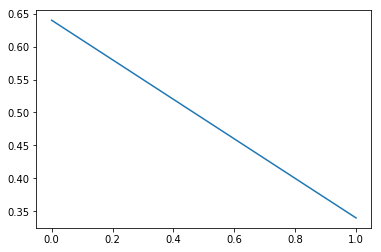

In [12]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)